# Classification supervisée

In [158]:
import pandas as pd
import numpy as np
import scipy.stats as sps

# Plot et Display
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# Scikit learn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier 

#Lecture des données 
import pickle

In [159]:
#path_test = "../../4A/Projet/Ensemble de test/"
path_test = "../Donnees_projet/Ensemble_de_test/"

In [160]:
with open('liste_propre', 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    liste_propre, ind_recupere = mon_depickler.load()

In [161]:
n = len(liste_propre)
liste_appr = list(np.asarray(liste_propre)[np.asarray(ind_recupere) <= 299])
liste_test = list(np.asarray(liste_propre)[np.asarray(ind_recupere) > 299])
n_appr = len(liste_appr)
n_test = len(liste_test)

In [162]:
anom = [False] * n_test
type_anom = [-1] * n_test
loc = [-1] * n_test

anom[73] = True
type_anom[73] = 1
loc[73] = 200

anom[96] = True
type_anom[96] = 1
loc[96] = 300

anom[36] = True
type_anom[36] = 1
loc[36] = 400

anom[32] = True
type_anom[32] = 1
loc[32] = 300

anom[33] = True
type_anom[33] = 1
loc[33] = 200

anom[107] = True
type_anom[107] = 2
loc[107] = 600

anom[60] = True
type_anom[60] = 2
loc[60] = 400

anom[113] = True
type_anom[113] = 2
loc[113] = 400

anom[9] = True
type_anom[9] = 2
loc[9] = 200

anom[11] = True
type_anom[11] = 2
loc[11] = 300

anom[53] = True
type_anom[53] = 3
loc[53] = 400

anom[114] = True
type_anom[114] = 3
loc[114] = 400

anom[14] = True
type_anom[14] = 3
loc[14] = 500

anom[79] = True
type_anom[79] = 3
loc[79] = 400

anom[29] = True
type_anom[29] = 3
loc[29] = 300

anom[27] = True
type_anom[27] = 4
loc[27] = 300

anom[121] = True
type_anom[121] = 4
loc[121] = 300

anom[5] = True
type_anom[5] = 4
loc[5] = 400

anom[89] = True
type_anom[89] = 4
loc[89] = 200

anom[99] = True
type_anom[99] = 4
loc[99] = 100  

anom = [False] * n_appr + anom
type_anom = [-1] * n_appr + type_anom
loc = [-1] * n_appr + loc

In [163]:
ind_anom = list(np.where(np.asarray(anom))[0]) # Indices des anomalies

In [164]:
def df_fenetres(liste_comp, N, anom, loc):
    serie = []
    #origine = []
    ind_debut = []
    valeurs = []
    anom_fen = []
    for i, val, loc_i in zip(ind_recupere, liste_comp, loc):
        # Liste des fenêtres de l'enregistrement
        fenetres = [val[i * N:(i + 1) * N] for i in range((len(val) + N - 1) // N ) if len(val[i * N:(i + 1) * N]) == N]
        nb_fen = len(fenetres)
        valeurs += fenetres
        anom_fen_i = [False] * nb_fen
        pos_anom_deb_fen = loc_i // N
        pos_anom_fin_fen = (loc_i + 55) // N
        if loc_i > -1:
            try:
                for pos in range(pos_anom_deb_fen, pos_anom_fin_fen + 1):
                    anom_fen_i[pos] = True

            except IndexError:
                pass
                """Cette erreur est levée lorsque l'anomalie se trouve en fin de série, dans une plage qui n'a pas été capturée 
                par une des fenêtres. On peut donc l'ignorer et continuer le traitement. Ce cas est de toute façon très rare
                dans nos données."""
        anom_fen += anom_fen_i
        ind_debut += list(range(0, nb_fen * N, N))
        serie += [i] * nb_fen
        """if i < 300:
            origine += ["appr"] * nb_fen
        else:
            origine += ["test"] * nb_fen"""
        
    
    df = pd.DataFrame(data={"id" : list(range(len(serie))), "serie" : serie, "ind_debut" : ind_debut, "valeurs" : valeurs, "anom" : anom_fen})
        
    return df.set_index(["id"])

In [165]:
N = 200
data_fenetres = df_fenetres(liste_propre, N, anom, loc)

In [166]:
ind_anom = list(data_fenetres[data_fenetres["anom"]]["serie"].values)

In [167]:
# Toutes les fenetres des séries contenant une anomalie
data_ajout_anom = data_fenetres.loc[data_fenetres["serie"].isin(ind_anom)] 
# On met un indice d'une grande puisance de 10 pour identifier plus facilement les fenetres ajoutees
offset = 10 ** (int(np.log10(data_fenetres.index.values[-1])) + 1)

df_supervise = data_fenetres
for i in range(1,5):
    data_ajout_anom.index += offset
    df_supervise = pd.concat([df_supervise, data_ajout_anom])
    
# df_supervise contient les données d'apprentissage + les données de tests + les séries anormales recopiées 4 fois
# les séries recopiées ont pour indice leur indice de départ + k*offset pour k=1,..,4
df_supervise.tail(50)

,serie,ind_debut,valeurs,anom
id,,,,
31220,413,400,"[1674.0, 1682.0, 1682.0, 1698.0, 1698.0, 1698....",True
31246,421,0,"[1416.0, 1400.0, 1400.0, 1408.0, 1408.0, 1408....",False
31247,421,200,"[1728.0, 1728.0, 1744.0, 1736.0, 1728.0, 1720....",True
40884,305,0,"[1432.0, 1432.0, 1440.0, 1432.0, 1416.0, 1416....",False
40885,305,200,"[2920.0, 2552.0, 2120.0, 1752.0, 1624.0, 1576....",False
40886,305,400,"[1250.0, 1234.0, 1234.0, 1258.0, 1258.0, 1274....",True
40887,305,600,"[1576.0, 1576.0, 1576.0, 1584.0, 1584.0, 1576....",False
40897,309,0,"[1416.0, 1416.0, 1408.0, 1408.0, 1400.0, 1408....",False
40898,309,200,"[1674.0, 1682.0, 1682.0, 1698.0, 1698.0, 1698....",True


In [168]:
def plot_anom_type(Type):
    for num in df_supervise.index.values:
        TS = df_supervise.loc[num]
        loc = TS["loc"]
        serie = TS["valeurs"]

        if TS["type"] == Type: 
            fig, ax = plt.subplots(figsize=(12, 7))
            plt.title("Série numéro " + str(num) + ", type " + str(Type), size=20, color='r', fontweight='bold')

            ax.plot(range(loc), serie[: loc], 'b')
            ax.plot(range(loc - 1, loc + 56), serie[loc - 1 : loc + 56], 'r')
            ax.plot(range(loc + 55, len(serie)), serie[loc + 55 :], 'b')

        plt.show()

In [169]:
try:
    for T in range(1, 5):
        plot_anom_type(T)
except KeyError:
    print("Marche plus avec le nouveau DataFrame, à adapter si besoin.")

Marche plus avec le nouveau DataFrame, à adapter si besoin.


## Méthodes de Classification

## Random Forest

### Calcul des features

In [170]:
df_supervise["min"] = list(map(min, df_supervise.valeurs))
df_supervise["max"] = list(map(max, df_supervise.valeurs))
df_supervise["mean"] = list(map(np.mean, df_supervise.valeurs))
df_supervise["std"] = list(map(np.std, df_supervise.valeurs))
df_supervise["skew"] = list(map(sps.skew, df_supervise.valeurs))
df_supervise["kurt"] = list(map(sps.kurtosis, df_supervise.valeurs))
df_supervise["energy"] = list(map(lambda x : sum(np.asarray(x)**2)/len(x), df_supervise.valeurs))
df_supervise["average_cross"] = list(map(lambda x : sum(1*(x > np.mean(x)))/len(x), df_supervise.valeurs))

In [171]:
scaler = preprocessing.StandardScaler()
names_features = ["min", "max", "mean", "std", "skew", "kurt", "energy", "average_cross"]
for col in names_features:
    df_supervise[col] = scaler.fit_transform(df_supervise[col].values.reshape(-1, 1))

In [172]:
df_supervise.shape

(1453, 12)

In [189]:
taille_test = df_supervise.shape[0] // 3
X_train, X_test, Y_train, Y_test = train_test_split(df_supervise[names_features], df_supervise["anom"], test_size=taille_test)

In [190]:
# définition des paramètres
forest = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, min_samples_split=2,
                                min_samples_leaf=1, max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=True)
# apprentissage
rfFit = forest.fit(X_train, Y_train)
print(1 - rfFit.oob_score_)

0.0020639834881320818


In [191]:
# erreur de prévision sur le test
1 - rfFit.score(X_test, Y_test)

0.004132231404958664

In [192]:
param = [{"max_features" : list(range(2, len(names_features) + 1))}]
rf = GridSearchCV(RandomForestClassifier(n_estimators=500), param, cv=5, n_jobs=-1)
rfOpt = rf.fit(X_train, Y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

Meilleur score = 0.002064, Meilleur paramètre = {'max_features': 2}


In [193]:
# erreur de prévision sur le test
1 - rfOpt.score(X_test,Y_test)

0.006198347107438051

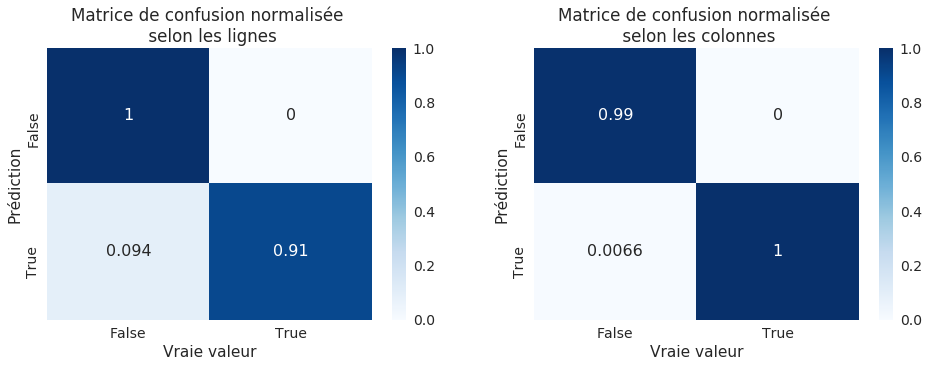

In [194]:
# prévision
y_chap = rfOpt.predict(X_test)
# matrice de confusion
# Options pour normalize : all, index, column
table_norm_index = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="index") # margins=True, margins_name="Total")
table_norm_col = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="columns")
sns.set(font_scale=1.4)#for label size
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.heatmap(table_norm_index, annot=True, cmap="Blues", ax=ax[0], annot_kws={"size": 16}) # font size
ax[0].set_title("Matrice de confusion normalisée \n selon les lignes")
sns.heatmap(table_norm_col, annot=True, cmap="Blues", ax=ax[1], annot_kws={"size": 16}) # font size
ax[1].set_title("Matrice de confusion normalisée \n selon les colonnes")
plt.show()

Commentaire : 1,2% d'erreurs, c'est très faible mais si on regarde la matrice de confusion on voit que la prévision n'est en fait pas si efficace. En effet on observe beaucoup de faux négatifs, envion un tiers. On a pas contre quasi aucun faux positif.

On teste la même chose mais sans dupliquer les anomalies.

In [179]:
data_fenetres["min"] = list(map(min, data_fenetres.valeurs))
data_fenetres["max"] = list(map(max, data_fenetres.valeurs))
data_fenetres["mean"] = list(map(np.mean, data_fenetres.valeurs))
data_fenetres["std"] = list(map(np.std, data_fenetres.valeurs))
data_fenetres["skew"] = list(map(sps.skew, data_fenetres.valeurs))
data_fenetres["kurt"] = list(map(sps.kurtosis, data_fenetres.valeurs))
data_fenetres["energy"] = list(map(lambda x : sum(np.asarray(x)**2)/len(x), data_fenetres.valeurs))
data_fenetres["average_cross"] = list(map(lambda x : sum(1*(x > np.mean(x)))/len(x), data_fenetres.valeurs))

In [180]:
scaler = preprocessing.StandardScaler()
names_features = ["min", "max", "mean", "std", "skew", "kurt", "energy", "average_cross"]
for col in names_features:
    data_fenetres[col] = scaler.fit_transform(data_fenetres[col].values.reshape(-1, 1))

In [181]:
data_fenetres.shape

(1265, 12)

In [196]:
taille_test = data_fenetres.shape[0] // 3
X_train, X_test, Y_train, Y_test = train_test_split(data_fenetres[names_features], data_fenetres["anom"], test_size=taille_test)

In [197]:
# définition des paramètres
forest = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,
                                max_features='auto', max_leaf_nodes=None, bootstrap=True, oob_score=True)
# apprentissage
rfFit = forest.fit(X_train, Y_train)
print(1 - rfFit.oob_score_)

0.011848341232227444


In [199]:
# erreur de prévision sur le test
1 - rfFit.score(X_test, Y_test)

0.014251781472684133

In [200]:
param = [{"max_features" : list(range(2, len(names_features) + 1))}]
rf = GridSearchCV(RandomForestClassifier(n_estimators=500), param, cv=5, n_jobs=-1)
rfOpt = rf.fit(X_train, Y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_, rfOpt.best_params_))

Meilleur score = 0.009479, Meilleur paramètre = {'max_features': 3}


In [201]:
# erreur de prévision sur le test
1 - rfOpt.score(X_test, Y_test)

0.014251781472684133

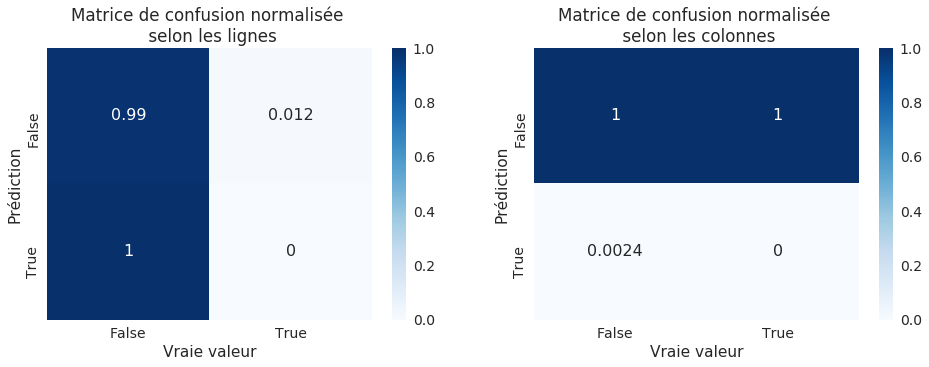

In [202]:
# prévision
y_chap = rfFit.predict(X_test)
# matrice de confusion
# Options pour normalize : all, index, column
table_norm_index = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="index") # margins=True, margins_name="Total")
table_norm_col = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="columns")
sns.set(font_scale=1.4)#for label size
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))
sns.heatmap(table_norm_index, annot=True, cmap="Blues", ax=ax[0], annot_kws={"size": 16}) # font size
ax[0].set_title("Matrice de confusion normalisée \n selon les lignes")
sns.heatmap(table_norm_col, annot=True, cmap="Blues", ax=ax[1], annot_kws={"size": 16}) # font size
ax[1].set_title("Matrice de confusion normalisée \n selon les colonnes")
plt.show()

Commentaire : Le modèle répond quasi systématiquement Non, et donc se trompe très peu. C'est parfaitement inexploitable, il faut garder la version en dupliquant les anomalies ou trouver une autre idée.

### Coefficients de Fourier

In [203]:
from scipy.fftpack import fft
fftCoeff =[]
for x in df_supervise["valeurs"]:
    mx = np.mean(x)
    x_centre = x - mx
    #Apply fast Fourier transform
    coeffsfft = np.abs(fft(x_centre))
    coeffsfft_flatten = np.hstack(coeffsfft)
    fftCoeff.append(coeffsfft_flatten)
    
fftCoeff = np.array(fftCoeff)
print(fftCoeff.shape)

#Coefficients seuillés
prop_a_garder = 0.1
nb_coeffs = int(fftCoeff.shape[1] * prop_a_garder)
somme = np.sum(fftCoeff**2, axis=0)
fftCoeff_seuil = np.zeros((0, nb_coeffs))
ind_grands = np.argsort(somme)[-nb_coeffs :]
fftCoeff_seuil = fftCoeff[:, ind_grands]

print(fftCoeff_seuil.shape)

(1453, 200)
(1453, 20)


In [204]:
df_Fourier = pd.DataFrame(fftCoeff)
df_Fourier_seuil = pd.DataFrame(fftCoeff_seuil)

In [205]:
for col in df_Fourier.columns :
    df_Fourier[col] = scaler.fit_transform(df_Fourier[col].values.reshape(-1, 1))
for col in df_Fourier_seuil.columns :
    df_Fourier_seuil[col] = scaler.fit_transform(df_Fourier_seuil[col].values.reshape(-1, 1))

### Coefficients d'ondelettes

In [206]:
import pywt
from pywt import wavedec
from statsmodels.robust import mad

wavelist=['haar', 'db2']

wavelist=['haar', 'db2'] 

Coeff_ond_haar = []
Coeff_ond_db2 = []

for x in df_supervise["valeurs"]:
    #Apply wavelet decomposition
    coeffs_haar = pywt.wavedec(x,wavelist[0],level=4) 
    coeffs_flatten_haar, coeff_slices_haar = pywt.coeffs_to_array(coeffs_haar)
    Coeff_ond_haar.append(coeffs_flatten_haar)
    #Apply wavelet decomposition
    coeffs_db2 = pywt.wavedec(x,wavelist[1],level=4) 
    coeffs_flatten_db2, coeff_slices_db2 = pywt.coeffs_to_array(coeffs_db2)
    Coeff_ond_db2.append(coeffs_flatten_db2)
    
    
Coeff_ond_haar = np.array(Coeff_ond_haar)
Coeff_ond_db2 = np.array(Coeff_ond_db2)
print(Coeff_ond_haar.shape, Coeff_ond_db2.shape)

/usr/local/insa/anaconda/lib/python3.6/site-packages/pywt/_multilevel.py:664: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  coeff_arr[a_slices] = a_coeffs
/usr/local/insa/anaconda/lib/python3.6/site-packages/pywt/_multilevel.py:690: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  coeff_arr[slice_array] = d


(1453, 201) (1453, 210)


In [207]:
df_ond_haar = pd.DataFrame(Coeff_ond_haar)
df_ond_db2 = pd.DataFrame(Coeff_ond_db2)

In [209]:
#for col in df_ond_haar.columns :
#    df_ond_haar[col] = scaler.fit_transform(df_ond_haar[col].values.reshape(-1, 1))
#for col in df_ond_db2.columns :
#    df_ond_db2[col] = scaler.fit_transform(df_ond_db2[col].values.reshape(-1, 1))

### Visualisation des résultats

In [221]:
# Interactive display
from ipywidgets import interact, widgets, interactive, fixed, interact_manual
from IPython.display import display

df_liste = ["Features",
            "Ondelettes_haar",
            "Ondelettes_db2",
            "Coefficients de Fourier",
            "Coefficients de Fourier seuillés"
           ]

dict_df = {"Features" : df_supervise[names_features],
           "Ondelettes_haar" : df_ond_haar,
           "Ondelettes_db2" : df_ond_db2,
           "Coefficients de Fourier" : df_Fourier,
           "Coefficients de Fourier seuillés" : df_Fourier_seuil
          }

taille_max = df_supervise.shape[0]

In [222]:
@interact(Choix_df=df_liste, taille_test=widgets.IntSlider(min=100, max=taille_max - 100, step=100, 
                                                           value=taille_max//3, continuous_update=False), 
          button=widgets.ToggleButton(description="Refresh"))

def RandomForest(Choix_df, taille_test, button):
    df_coeff = dict_df[Choix_df]
    print("Proportion de fenêtres utilisées pour l'apprentissage : ", 1 - taille_test / df_coeff.shape[0])
    X_train, X_test, Y_train, Y_test = train_test_split(df_coeff, df_supervise["anom"], test_size=taille_test)
    
    # définition des paramètres
    
    # apprentissage
    
    max_feat = 16
    param = [{"max_features" : list(range(2, min(max_feat, df_coeff.shape[1]) + 1))}]
    rf = GridSearchCV(RandomForestClassifier(n_estimators=500), param, cv=5, n_jobs=-1)

    rfOpt = rf.fit(X_train, Y_train)
    
    #print("Erreur Out of bag : ", 1 - rfOpt.oob_score_)  # N'existe pas sur les objets GridSearchCV, hélas
    # erreur de prévision sur le test
    print("Erreur de prévision sur le test : ", 1 - rfOpt.score(X_test, Y_test))
    # paramètre optimal
    print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_, rfOpt.best_params_))
    
    forest = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, min_samples_split=2,
                                    min_samples_leaf=1, max_features=rfOpt.best_params_['max_features'], 
                                    max_leaf_nodes=None, bootstrap=True, oob_score=True)
    rfFit = forest.fit(X_train, Y_train)
    
    # prévision
    y_chap = rfOpt.predict(X_test)
    # matrice de confusion
    table = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize=False) # margins=True, margins_name="Total")
    table_norm = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="all")
    table_norm_index = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="index") # margins=True, margins_name="Total")
    table_norm_col = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="columns")
    sns.set(font_scale=1.4)  #for label size
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
    sns.heatmap(table, annot=True, cmap="Blues", ax=ax[0, 0], annot_kws={"size": 16})  # font size
    ax[0, 0].set_title("Matrice de confusion brute")
    sns.heatmap(table_norm, annot=True, cmap="Blues", ax=ax[0, 1], annot_kws={"size": 16}) # font size
    ax[0, 1].set_title("Matrice de confusion normalisée")
    sns.heatmap(table_norm_index, annot=True, cmap="Blues", ax=ax[1, 0], annot_kws={"size": 16}) # font size
    ax[1, 0].set_title("Matrice de confusion normalisée selon les lignes")
    sns.heatmap(table_norm_col, annot=True, cmap="Blues", ax=ax[1, 1], annot_kws={"size": 16}) # font size
    ax[1, 1].set_title("Matrice de confusion normalisée selon les colonnes")
    plt.show()

interactive(children=(Dropdown(description='Choix_df', options=('Features', 'Ondelettes_haar', 'Ondelettes_db2…

**Commentaires :**

Très peu d'erreur avec les coefficients d'ondelettes (haar ou db2) et même parfois 0 erreur.

Avec les coefficients de Fourier : résulats quasi identiques à ceux de Features, parfois meilleurs, parfois pires.

### A FINIR

In [225]:
# RandomForest sur coefficients d'ondelettes db2

X_train, X_test, Y_train, Y_test = train_test_split(Coeff_ond_db2, df_supervise["anom"],
                                                    test_size=Coeff_ond_db2.shape[1] // 3)

max_feat = 16
param = [{"max_features" : list(range(2, min(max_feat, Coeff_ond_db2.shape[1]) + 1))}]
rf = GridSearchCV(RandomForestClassifier(n_estimators=500), param, cv=5, n_jobs=-1)
rfOpt = rf.fit(X_train, Y_train)

# erreur de prévision sur le test
print("Erreur de prévision sur le test : ", 1 - rfOpt.score(X_test, Y_test))
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_, rfOpt.best_params_))

# forest optimal
forest = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, min_samples_split=2,
                                min_samples_leaf=1, max_features=2, max_leaf_nodes=None, bootstrap=True,
                                oob_score=True)
rfFit = forest.fit(X_train, Y_train)

Erreur de prévision sur le test :  0.0
Meilleur score = 0.000000, Meilleur paramètre = {'max_features': 2}


In [233]:
print("Importance de chaque coefficient : ", rfFit.feature_importances_)

Importance de chaque coefficient :  [0.00597548 0.00767178 0.00666999 0.00586374 0.00606846 0.00735334
 0.00317973 0.00385766 0.00891802 0.01196325 0.01039841 0.00395548
 0.0036462  0.00324075 0.00325953 0.00440324 0.00518453 0.00421271
 0.00519012 0.00411065 0.00321428 0.00358954 0.00525248 0.00507993
 0.00346851 0.00750018 0.0060337  0.00282471 0.00307009 0.00237688
 0.00288696 0.00402172 0.00430879 0.00466001 0.01467463 0.00894199
 0.00521311 0.00663589 0.00523584 0.00320174 0.00268379 0.00210298
 0.00437862 0.00424539 0.00627823 0.00634636 0.00441128 0.00445158
 0.00419254 0.00713615 0.00698318 0.00343657 0.00377664 0.00319332
 0.00260092 0.00222374 0.00251173 0.00336679 0.00279296 0.00472086
 0.00269034 0.0053522  0.00517014 0.01087091 0.00464368 0.00600103
 0.00712352 0.00452027 0.00429198 0.00737231 0.01091874 0.0055599
 0.00389517 0.00326701 0.00424578 0.00230693 0.00299155 0.00368114
 0.00274331 0.0034667  0.00371316 0.00373672 0.01001973 0.00491362
 0.00447567 0.006479   0.00

In [227]:
y_chap = rfOpt.predict(X_test)
y_chap

array([False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True,  True, False])

In [228]:
importance = rfFit.feature_importances_

In [235]:
# coefficients triés par ordre d'importance
np.argsort(rfFit.feature_importances_)[::-1] #dans l'ordre

array([136,  34,   9, 186,  70,  63, 137,  10, 113,  82, 117,  88, 116,
        35,   8, 169, 128, 127, 166, 159,   1, 125, 118,  25,  69,   5,
       167,  49,  66,  50, 170, 129, 123, 168,   2,  37,  85,  45,  96,
        44,  97, 180, 187,   4,  95,  26,  65,   0, 119,   3, 114, 173,
       121, 135, 111,  71, 120,  94, 183,  61,  22, 163, 181,  38, 112,
        36, 162,  18,  16,  62, 130, 102,  23, 131, 182, 165,  83, 122,
       126, 110, 160, 196,  59, 133,  91, 158,  33,  64,  86, 161, 175,
        67, 141,  84, 132,  47, 184,  46,  15,  42,  90, 134, 178,  32,
        68,  74,  43,  17,  89,  48,  19, 115,  99,  31,  93, 172, 155,
        11, 143,  72,   7,  92, 142,  52, 189, 138, 185,  81,  80,  98,
       200,  77, 174,  12,  87, 140,  21, 198, 157,  24,  79,  51, 164,
       156, 188,  57, 192,  73,  14,  13, 101, 104, 171, 197,  20, 205,
        39, 150,  53, 177,   6, 179, 124, 204, 176,  28, 144,  76, 190,
        30, 146, 199,  27, 108, 139,  58, 100,  78, 154, 103,  6

In [236]:
# on ne garde que les 10 coefficients les plus importants pour reconstruire un signal avec anomalie
seuil = np.sort(importance)[-10]
valeurs = df_ond_db2.loc[6, :].values
valeurs_seuil = np.array([v if imp >= seuil else 0 for imp, v in zip(importance, valeurs)])
valeurs_seuil

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  6.70267064e+03,  6.70127003e+03,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.76156634e-01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

/usr/local/insa/anaconda/lib/python3.6/site-packages/pywt/_multilevel.py:763: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  coeffs.append(arr[coeff_slices[0]])
/usr/local/insa/anaconda/lib/python3.6/site-packages/pywt/_multilevel.py:776: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  d[k] = arr[v]
/usr/local/insa/anaconda/lib/python3.6/site-packages/pywt/_multilevel.py:408: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpret

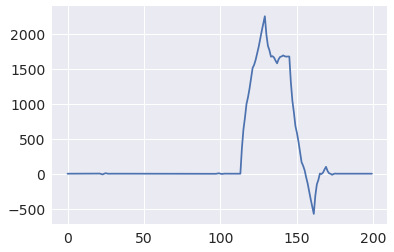

In [237]:
plt.plot(pywt.waverecn(pywt.array_to_coeffs(valeurs_seuil, coeff_slices), 'db2'))

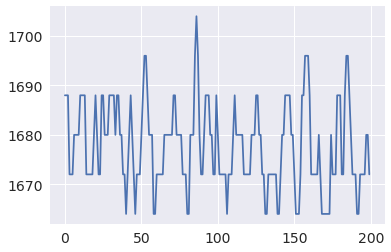

In [238]:
#le signal d'origine
plt.plot(np.array(df_supervise.loc[6, "valeurs"]))

Tester regression logistique
Pouvoir visualiser l'anomalie
Tester lissage spline ou supprimer les niveaux de détails les plus fins en ondelettes
